Install and load required packages

In [1]:
if(!require('h2o')){install.packages('h2o')}
if(!require('h2o4gpu')){install.packages('h2o4gpu')}
if(!require('getPass')){install.packages('getPass')}

Loading required package: h2o


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit https://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc


Loading required package: h2o4gpu


Attaching package: ‘h2o4gpu’


The following object is masked from ‘package:base’:

    transform


Loading required package: getPass



In [2]:
library('tidyverse')
library('caret')
library("DBI")
library('dplyr')
library('dbplyr')
library('tdplyr')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘caret’ was built under R version 4.0.5”
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


Registered S3 methods overwritten by 'tdplyr':
  method                     from  
  db_analyze.Teradata        dbplyr
  sql_select.Teradata        dbplyr
  sql_translate_env.Teradata dbplyr



Replace your cluster details for your user, password, host and database.

In [6]:
host <- "3.238.151.85"
user <- "AOA_DEMO"
database <- "AOA_DEMO"
password <- getPass::getPass("Enter the password: ")
params <- sprintf("{\"host\":\"%s\",\"user\":\"%s\",\"password\":\"%s\",\"database\":\"%s\"}", host, user, password, database)
con <- DBI::dbConnect(teradatasql::TeradataDriver(), paste0(params)) 

Enter the password:  ··········


Load the dataset

In [7]:
bank <- DBI::dbGetQuery(con, "select * from bank_marketing_data")
bank$job <- as.factor(bank$job)
bank$marital <- as.factor(bank$marital)
bank$education <- as.factor(bank$education)
bank$default <- as.factor(bank$default)
bank$balance <- as.integer(bank$balance)
bank$housing <- as.factor(bank$housing)
bank$loan <- as.factor(bank$loan)
bank$contact <- as.factor(bank$contact)
bank$day <- as.integer(bank$day)
bank$month <- as.factor(bank$month)
bank$pdays <- as.integer(bank$pdays)
bank$poutcome <- as.factor(bank$poutcome)
bank$y <- as.factor(bank$y)

Let's inspect the dataset

In [8]:
str(bank)

'data.frame':	4521 obs. of  17 variables:
 $ age      : int  30 33 35 30 59 35 36 39 41 43 ...
 $ job      : Factor w/ 12 levels "admin.","blue-collar",..: 11 8 5 5 2 5 7 10 3 8 ...
 $ marital  : Factor w/ 3 levels "divorced","married",..: 2 2 3 2 2 3 2 2 2 2 ...
 $ education: Factor w/ 4 levels "primary","secondary",..: 1 2 3 3 2 3 3 2 3 1 ...
 $ default  : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ balance  : int  1787 4789 1350 1476 0 747 307 147 221 -88 ...
 $ housing  : Factor w/ 2 levels "no","yes": 1 2 2 2 2 1 2 2 2 2 ...
 $ loan     : Factor w/ 2 levels "no","yes": 1 2 1 2 1 1 1 1 1 2 ...
 $ contact  : Factor w/ 3 levels "cellular","telephone",..: 1 1 1 3 3 1 1 1 3 1 ...
 $ day      : int  19 11 16 3 5 23 14 6 14 17 ...
 $ month    : Factor w/ 12 levels "apr","aug","dec",..: 11 9 1 7 9 4 9 9 9 1 ...
 $ duration : int  79 220 185 199 226 141 341 151 57 313 ...
 $ campaign : int  1 1 1 4 1 2 1 2 2 1 ...
 $ pdays    : int  -1 339 330 -1 -1 176 330 -1 -1 147 ...
 $ p

In [31]:
bank

age,job,marital,education,default,balance,housing,loan,y
<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
30,unemployed,married,primary,no,1787,no,no,no
33,services,married,secondary,no,4789,yes,yes,no
35,management,single,tertiary,no,1350,yes,no,no
30,management,married,tertiary,no,1476,yes,yes,no
59,blue-collar,married,secondary,no,0,yes,no,no
35,management,single,tertiary,no,747,no,no,no
36,self-employed,married,tertiary,no,307,yes,no,no
39,technician,married,secondary,no,147,yes,no,no
41,entrepreneur,married,tertiary,no,221,yes,no,no


Check for NA values

In [9]:
table(is.na(bank))


FALSE 
76857 

Find the number of unique ages to choose histogram bin number

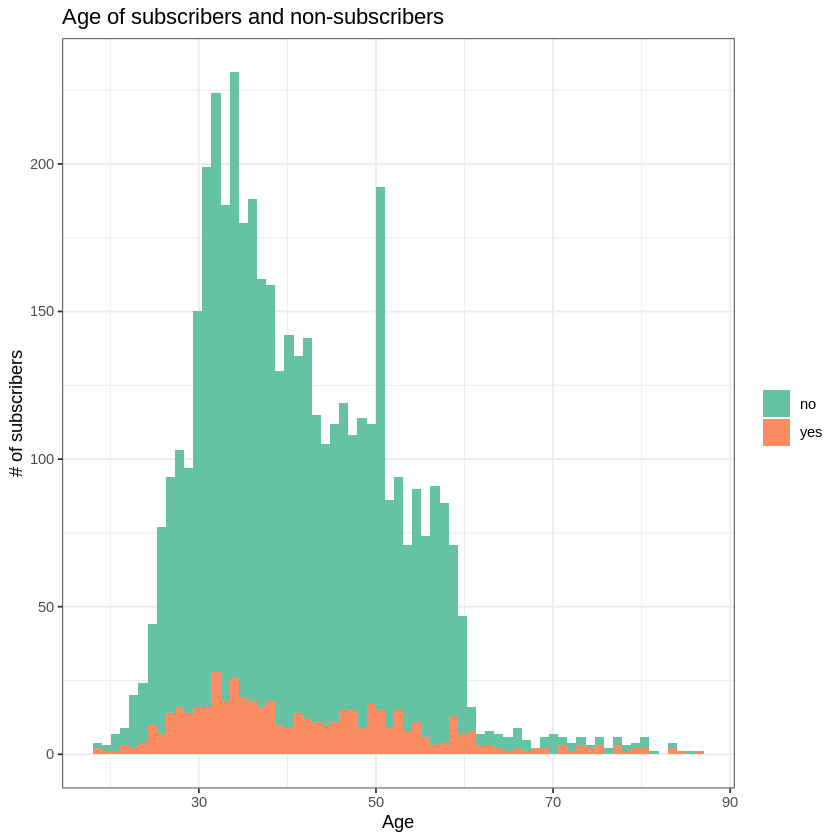

In [10]:
binnum <- length(unique(bank$age))

ggplot(bank, aes(age, fill = y)) + 
  geom_histogram(bins = binnum) + 
  ggtitle("Age of subscribers and non-subscribers") +
  xlab("Age") + 
  ylab("# of subscribers") +
  theme_bw() +
  scale_fill_brewer(palette="Set2") +
  theme(legend.title=element_blank())

In the histogram above we can see that there is one customer age that is significantly more prevalent than others.

Now I will visualize subscriber percentage by education level, marital status, occupation, and age:

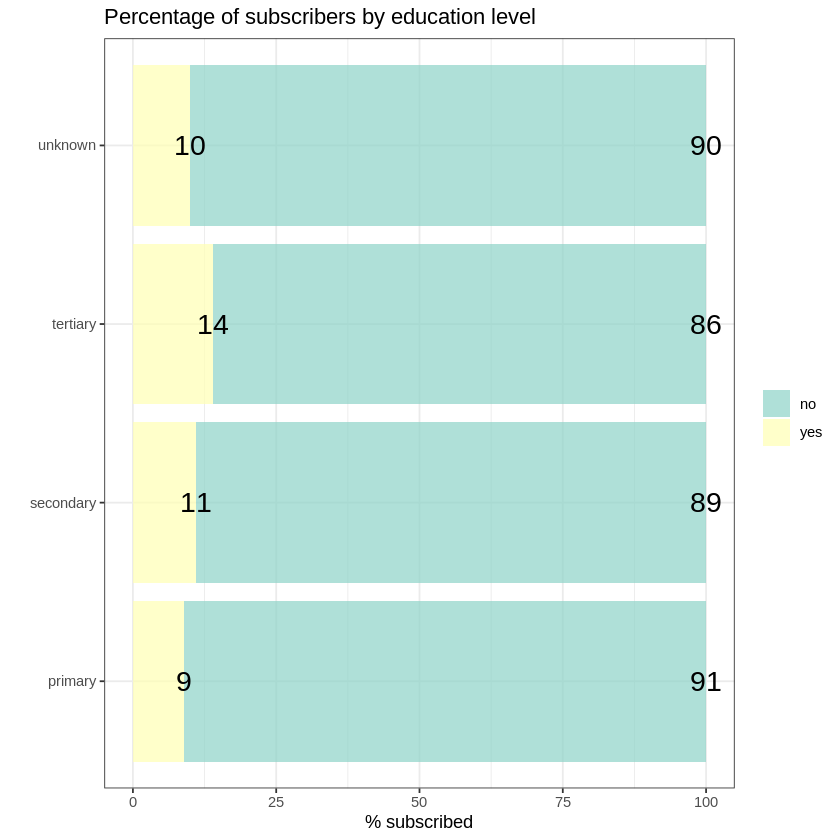

In [11]:
### subscriber % by education
yn <- bank %>% group_by(education, y) %>% summarise(n = n(), .groups = 'keep')
yed <- bank %>% group_by(education) %>% summarise(n = n())
jed <- left_join(yn, yed, by = "education")
jed <- jed %>% mutate(perc = round((n.x / n.y) * 100, digits = 0))

ggplot(jed, aes(x = education, y = perc, fill = y, label = perc)) + 
  geom_bar(stat = "identity", alpha = 0.7) + 
  geom_text(position = "stack", size = 6) + 
  ggtitle("Percentage of subscribers by education level") + 
  xlab("") +
  ylab("% subscribed") +
  scale_fill_brewer(palette="Set3") +
  theme_bw() +
  theme(legend.title=element_blank()) +
  coord_flip()

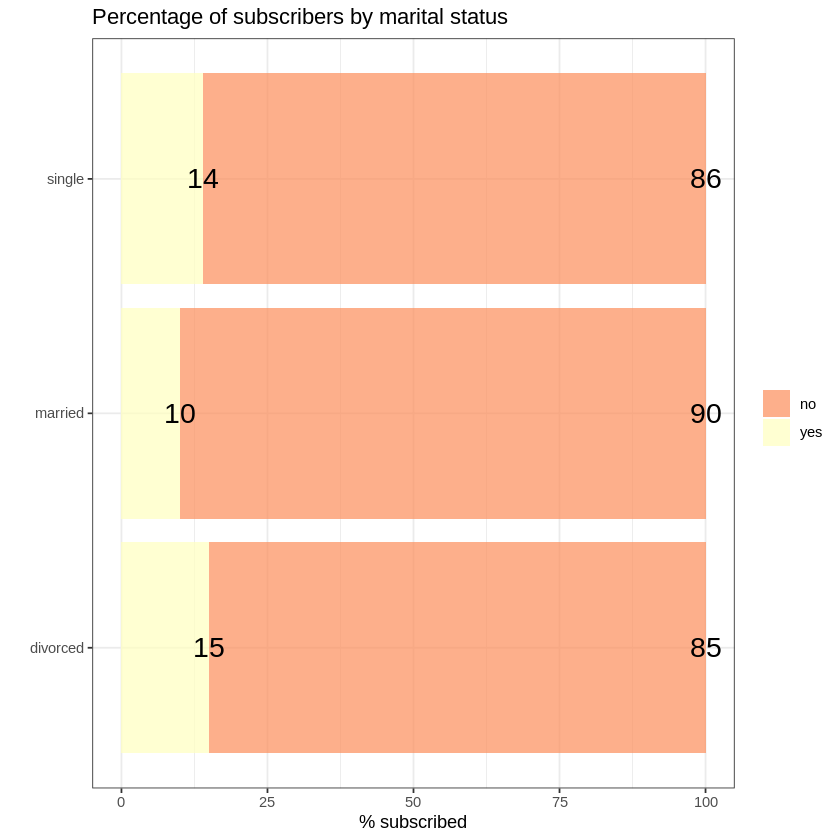

In [12]:
### subscriber % by marital status
mar <- bank %>% group_by(marital, y) %>% summarise(n = n(), .groups = 'keep')
ymar <- bank %>% group_by(marital) %>% summarise(n = n())
jmar <- left_join(mar, ymar, by = "marital")
jmar <- jmar %>% mutate(perc = round((n.x / n.y) * 100, digits = 0))

ggplot(jmar, aes(x = marital, y = perc, fill = y, label = perc)) + 
  geom_bar(stat = "identity", alpha = 0.7) + 
  geom_text(position = "stack", size = 6)  + 
  scale_fill_brewer(palette="Spectral") +
  ggtitle("Percentage of subscribers by marital status") +
  xlab("") +
  ylab("% subscribed") +
  theme_bw() +
  theme(legend.title=element_blank())+
  coord_flip()

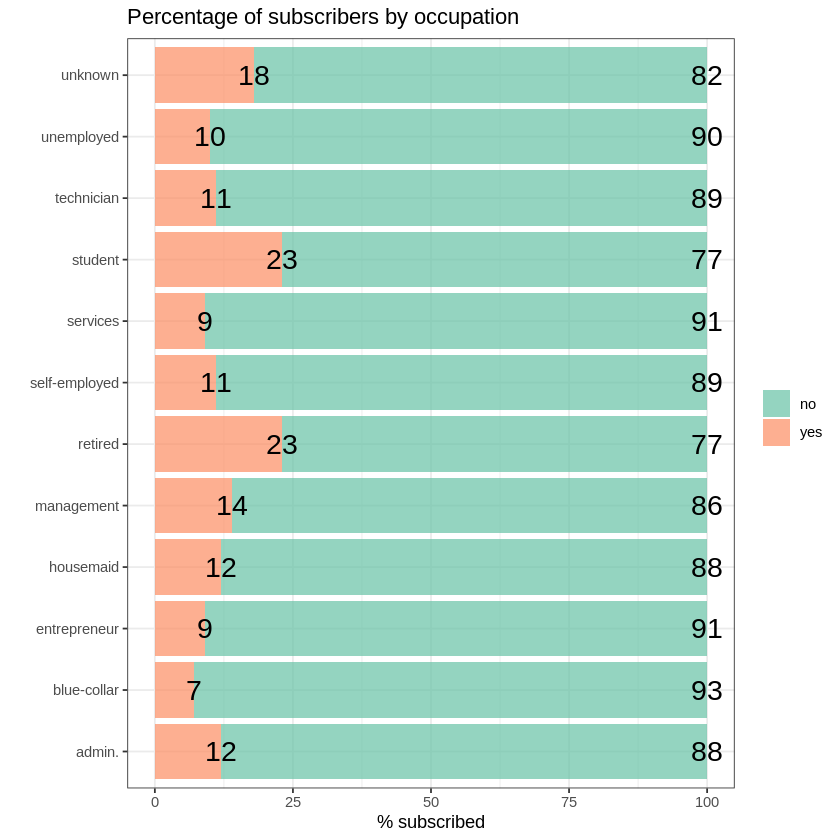

In [13]:
### subscribed by job type
ageout <- data.frame(table(bank$job, bank$y))
colnames(ageout) <- c("job", "y", "Freq")
jobs <- bank %>% group_by(job) %>% summarise(n = n())
aj <- left_join(ageout, jobs, by = "job")
aj <- aj %>% mutate(perc = round((Freq / n) * 100, digits = 0))

ggplot(aj, aes(x = job, y = perc, fill = y, label = perc)) + 
  geom_bar(stat = "identity", alpha = 0.7) + 
  geom_text(position = "stack", size = 6)  + 
  scale_fill_brewer(palette="Set2") +
  ggtitle("Percentage of subscribers by occupation") +
  xlab("") +
  ylab("% subscribed") +
  theme_bw() +
  theme(legend.title=element_blank())+
  coord_flip()

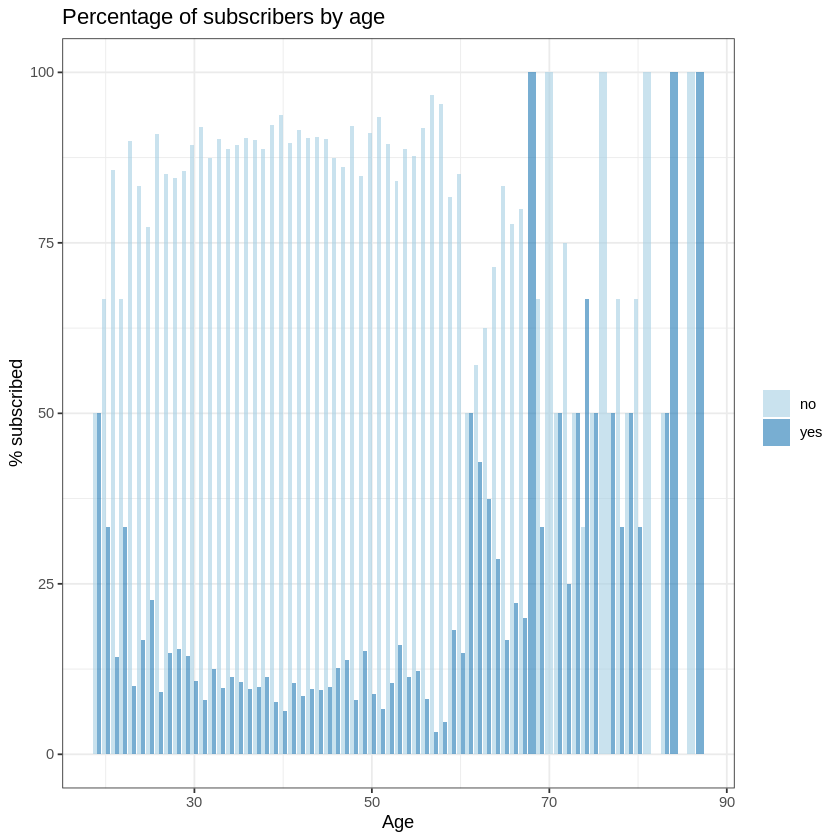

In [14]:
### subscriber by age
age <- bank %>% group_by(age, y) %>% summarise(n = n(), .groups = 'keep')
yage <- bank %>% group_by(age) %>% summarise(n = n())
jage <- left_join(age, yage, by = "age")
jage <- jage %>% mutate(perc = round((n.x / n.y) * 100, digits = 1))

ggplot(jage, aes(x = age, y = perc, fill = y, label = perc)) + 
  geom_bar(stat = "identity", position = "dodge", alpha = 0.6) + 
  scale_fill_brewer(palette="Paired") +
  ggtitle("Percentage of subscribers by age") +
  xlab("Age") +
  ylab("% subscribed") +
  theme_bw() +
  theme(legend.title=element_blank())

Upon completing the intial exploratory data analysis, I uploaded the dataset to H2O to run it through a GBM model. The model was trained on eight of the columns in the dataset: age, job, marital, education, default, balance, housing, loan

In [15]:
# Create Vantage connection using tdplyr
con <- td_create_context(host = host,
                         uid = user,
                         pwd = password,
                         dType = 'native'
)

# Set connection context
td_set_context(con)

In [16]:
table_name <- in_schema(database, 'bank_marketing_data')
table <- tbl(con, table_name)

bank <- table %>% select(c('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'y')) %>% as.data.frame()

bank$age <- as.integer(bank$age)
bank$job <- as.factor(bank$job)
bank$marital <- as.factor(bank$marital)
bank$education <- as.factor(bank$education)
bank$default <- as.factor(bank$default)
bank$balance <- as.integer(bank$balance)
bank$housing <- as.factor(bank$housing)
bank$loan <- as.factor(bank$loan)
bank$y <- as.factor(bank$y)
str(bank)

'data.frame':	4521 obs. of  9 variables:
 $ age      : int  30 33 35 30 59 35 36 39 41 43 ...
 $ job      : Factor w/ 12 levels "admin.","blue-collar",..: 11 8 5 5 2 5 7 10 3 8 ...
 $ marital  : Factor w/ 3 levels "divorced","married",..: 2 2 3 2 2 3 2 2 2 2 ...
 $ education: Factor w/ 4 levels "primary","secondary",..: 1 2 3 3 2 3 3 2 3 1 ...
 $ default  : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ balance  : int  1787 4789 1350 1476 0 747 307 147 221 -88 ...
 $ housing  : Factor w/ 2 levels "no","yes": 1 2 2 2 2 1 2 2 2 2 ...
 $ loan     : Factor w/ 2 levels "no","yes": 1 2 1 2 1 1 1 1 1 2 ...
 $ y        : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...


In [17]:
summary(bank)

      age                 job          marital         education    default   
 Min.   :19.00   management :969   divorced: 528   primary  : 678   no :4445  
 1st Qu.:33.00   blue-collar:946   married :2797   secondary:2306   yes:  76  
 Median :39.00   technician :768   single  :1196   tertiary :1350             
 Mean   :41.17   admin.     :478                   unknown  : 187             
 3rd Qu.:49.00   services   :417                                              
 Max.   :87.00   retired    :230                                              
                 (Other)    :713                                              
    balance      housing     loan        y       
 Min.   :-3313   no :1962   no :3830   no :4000  
 1st Qu.:   69   yes:2559   yes: 691   yes: 521  
 Median :  444                                   
 Mean   : 1423                                   
 3rd Qu.: 1480                                   
 Max.   :71188                                   
                  

Now we must initialize h2o and prepare the training dataset

In [18]:
h2o.init(nthreads = -1)
train_df <- as.h2o(bank)

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 days 6 hours 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.32.1.3 
    H2O cluster version age:    4 months and 10 days !!! 
    H2O cluster name:           H2O_started_from_R_jovyan_vba422 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.62 GB 
    H2O cluster total cores:    1 
    H2O cluster allowed cores:  1 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 4.0.3 (2020-10-10) 


Warning message in h2o.clusterInfo():
“
Your H2O cluster version is too old (4 months and 10 days)!
Please download and install the latest version from http://h2o.ai/download/”



  |======================================================================| 100%


We split the training dataset

In [19]:
splits <- h2o.splitFrame(train_df, 0.75, seed=1234)

We initally train with 50 ntrees, 2 max depth and 2 min rows. Then we evaluate the predictions with the other split.

In [20]:
model <- h2o.gbm(x = c(1:8), y = 9, training_frame = splits[[1]], categorical_encoding = 'auto', ntrees = 50, max_depth = 2, min_rows = 2, learn_rate = 0.1)
pred <- h2o.predict(model, splits[[2]])

  |======================================================================| 100%
  |======================================================================| 100%


In [21]:
# Eval performance:
perf <- h2o.performance(model)
perf

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.09070706
RMSE:  0.3011761
LogLoss:  0.3167571
Mean Per-Class Error:  0.3633824
AUC:  0.7224752
AUCPR:  0.2930073
Gini:  0.4449503
R^2:  0.07874112

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         no yes    Error       Rate
no     2544 476 0.157616  =476/3020
yes     214 162 0.569149   =214/376
Totals 2758 638 0.203180  =690/3396

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.139753    0.319527 178
2                       max f2  0.100886    0.458760 259
3                 max f0point5  0.218462    0.332992  84
4                 max accuracy  0.339259    0.893110  32
5                max precision  0.707215    1.000000   0
6                   max recall  0.042585    1.000000 383
7              max specificity  0.707215    1.000000   0
8             max absolute_mcc  0.165812

In [22]:
# Extract feature interactions:
feature_interactions <- h2o.feature_interaction(model)
feature_interactions

interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
loan,1.497338,10,9.4829211,0.9482921,0.1497338,1.2477369,7,6,5,2,8,6,5.666667,22.60000,0.2000000
education,4.203318,8,3.0453475,0.3806684,0.5254148,0.9644172,6,7,7,7,5,7,6.500000,40.25000,1.0000000
housing,6.453079,11,10.9213780,0.9928525,0.5866436,6.2839613,5,4,4,1,4,4,3.666667,17.72727,0.2727273
default,1.489883,1,0.4363958,0.4363958,1.4898834,0.6501788,8,8,8,6,1,8,6.500000,12.00000,1.0000000
balance,16.232924,37,28.7703180,0.7775762,0.4387277,12.2952646,2,2,1,3,6,1,2.500000,29.94595,0.6756757
marital,9.497456,11,8.0164901,0.7287718,0.8634051,6.7386165,4,5,6,4,2,3,4.000000,16.36364,0.8181818
job,21.805783,33,11.9293287,0.3614948,0.6607813,8.2800003,1,3,3,8,3,2,3.333333,25.66667,0.9393939
age,13.145834,39,27.3978210,0.7025082,0.3370727,5.5450656,3,1,2,5,7,5,3.833333,20.12821,0.5384615
interaction,gain,fscore,wfscore,average_wfscore,average_gain,expected_gain,gain_rank,fscore_rank,wfscore_rank,avg_wfscore_rank,avg_gain_rank,expected_gain_rank,average_rank,average_tree_index,average_tree_depth


The h2o.predict function outputs a data frame with “no” and “yes” prediction columns with the percentage and the prediction column. With this dataframe we can get the accurracy of our model with a confusion matrix.

In [23]:
tester <- as.data.frame(splits[[2]])
pred_df <- as.data.frame(pred)

library(caret)
confusionMatrix(tester$y, pred_df$predict)

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  831 149
       yes  98  47
                                          
               Accuracy : 0.7804          
                 95% CI : (0.7551, 0.8043)
    No Information Rate : 0.8258          
    P-Value [Acc > NIR] : 0.999958        
                                          
                  Kappa : 0.1497          
                                          
 Mcnemar's Test P-Value : 0.001466        
                                          
            Sensitivity : 0.8945          
            Specificity : 0.2398          
         Pos Pred Value : 0.8480          
         Neg Pred Value : 0.3241          
             Prevalence : 0.8258          
         Detection Rate : 0.7387          
   Detection Prevalence : 0.8711          
      Balanced Accuracy : 0.5672          
                                          
       'Positive' Class : no              
                              

In our first training the accuracy is 0,78 so we will try with other hyperparameters to find a better result.

Let's try with a setting of ntrees = 100, max_depth = 5 and min_rows = 3.

In [24]:
model <- h2o.gbm(x = c(1:8), y = 9, training_frame = splits[[1]], categorical_encoding = 'auto', ntrees = 100, max_depth = 5, min_rows = 3, learn_rate = 0.1)
pred <- h2o.predict(model, splits[[2]])

  |======================================================================| 100%
  |======================================================================| 100%


In [25]:
# Eval performance:
perf <- h2o.performance(model)
perf

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.06177043
RMSE:  0.2485366
LogLoss:  0.2202796
Mean Per-Class Error:  0.1987319
AUC:  0.9166554
AUCPR:  0.7284915
Gini:  0.8333107
R^2:  0.3726337

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         no yes    Error       Rate
no     2912 108 0.035762  =108/3020
yes     136 240 0.361702   =136/376
Totals 3048 348 0.071849  =244/3396

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.209534    0.662983 156
2                       max f2  0.156831    0.675095 194
3                 max f0point5  0.303787    0.750000 115
4                 max accuracy  0.281344    0.935512 122
5                max precision  0.950483    1.000000   0
6                   max recall  0.032192    1.000000 356
7              max specificity  0.950483    1.000000   0
8             max absolute_mcc  0.261898 

In [26]:
pred_df <- as.data.frame(pred)
confusionMatrix(tester$y, pred_df$predict)

Confusion Matrix and Statistics

          Reference
Prediction  no yes
       no  913  67
       yes 121  24
                                          
               Accuracy : 0.8329          
                 95% CI : (0.8098, 0.8542)
    No Information Rate : 0.9191          
    P-Value [Acc > NIR] : 1.0000000       
                                          
                  Kappa : 0.1155          
                                          
 Mcnemar's Test P-Value : 0.0001109       
                                          
            Sensitivity : 0.8830          
            Specificity : 0.2637          
         Pos Pred Value : 0.9316          
         Neg Pred Value : 0.1655          
             Prevalence : 0.9191          
         Detection Rate : 0.8116          
   Detection Prevalence : 0.8711          
      Balanced Accuracy : 0.5734          
                                          
       'Positive' Class : no              
                              

The accuracy has increased significantly. Let's try now with a setting of ntrees = 200, max_depth = 10 and min_rows = 5.

In [27]:
model <- h2o.gbm(x = c(1:8), y = 9, training_frame = splits[[1]], categorical_encoding = 'auto', ntrees = 200, max_depth = 10, min_rows = 5, learn_rate = 0.1)
pred <- h2o.predict(model, splits[[2]])

  |======================================================================| 100%
  |======================================================================| 100%


In [28]:
# Eval performance:
perf <- h2o.performance(model)
perf

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.002357139
RMSE:  0.04855038
LogLoss:  0.01832112
Mean Per-Class Error:  0.002323165
AUC:  0.999978
AUCPR:  0.9998243
Gini:  0.999956
R^2:  0.9760599

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
         no yes    Error     Rate
no     3014   6 0.001987  =6/3020
yes       1 375 0.002660   =1/376
Totals 3015 381 0.002061  =7/3396

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold       value idx
1                       max f1  0.385356    0.990753 183
2                       max f2  0.288109    0.995763 184
3                 max f0point5  0.685888    0.996220 177
4                 max accuracy  0.685888    0.997939 177
5                max precision  0.998756    1.000000   0
6                   max recall  0.288109    1.000000 184
7              max specificity  0.998756    1.000000   0
8             max absolute_mcc  0.385356    0.

Confusion Matrix and Statistics

     
       no yes
  no  950 135
  yes  30  10
                                          
               Accuracy : 0.8533          
                 95% CI : (0.8313, 0.8735)
    No Information Rate : 0.8711          
    P-Value [Acc > NIR] : 0.9641          
                                          
                  Kappa : 0.0555          
                                          
 Mcnemar's Test P-Value : 5.661e-16       
                                          
            Sensitivity : 0.96939         
            Specificity : 0.06897         
         Pos Pred Value : 0.87558         
         Neg Pred Value : 0.25000         
             Prevalence : 0.87111         
         Detection Rate : 0.84444         
   Detection Prevalence : 0.96444         
      Balanced Accuracy : 0.51918         
                                          
       'Positive' Class : no              
                                          

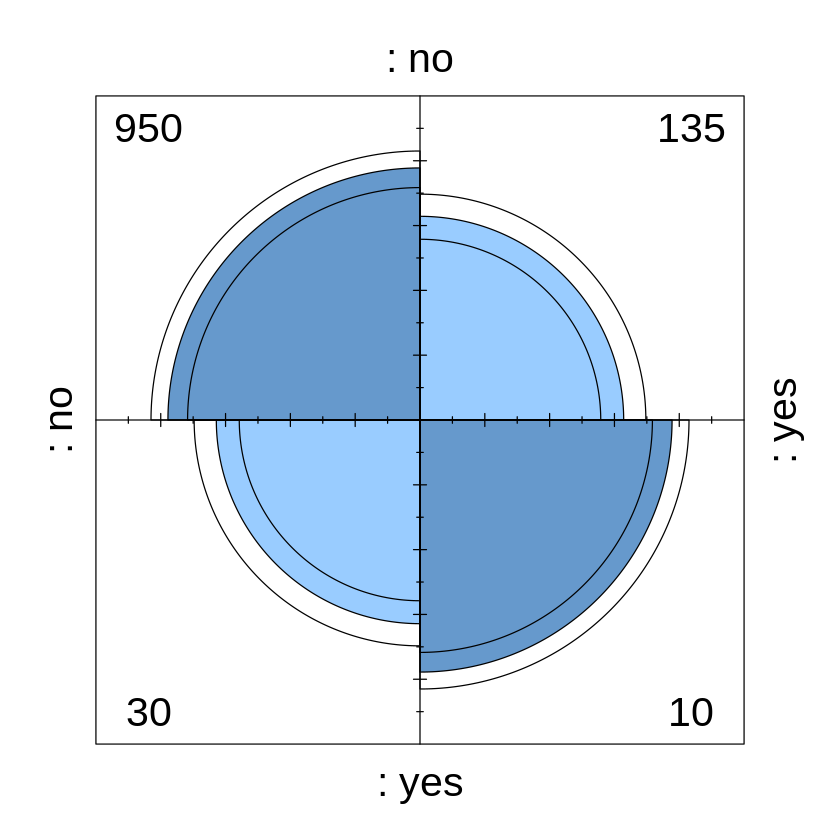

In [29]:
pred_df <- as.data.frame(pred)
library(caret)
cm <- confusionMatrix(table(pred_df$predict, tester$y))
cm
fourfoldplot(cm$table)
#png("artifacts/output/confusion_matrix.png", width = 860, height = 860)

In [30]:
cm$overall

Accuracy          Kappa  AccuracyLower  AccuracyUpper   AccuracyNull 
  8.533333e-01   5.546368e-02   8.312943e-01   8.735055e-01   8.711111e-01 
AccuracyPValue  McnemarPValue 
  9.640867e-01   5.661458e-16

In these examples, the model accuracy has improved greatly, with the true positive rate more than doubling and the overall accuracy rising from 78.04 percent to 85.33 percent

In [38]:
dfx <- data.frame (age  = c("32"),
                   job = c("blue-collar"),
                   marital = c("married"),
                   education  = c("tertiary"),
                   default  = c("no"),
                   balance  = c("5883"),
                   housing  = c("yes"),
                   loan  = c("yes")
                  )
data <-   dfx  
data$age <- as.integer(data$age)
    data$job <- as.factor(data$job)
    data$marital <- as.factor(data$marital)
    data$education <- as.factor(data$education)
    data$default <- as.factor(data$default)
    data$balance <- as.integer(data$balance)
    data$housing <- as.factor(data$housing)
    data$loan <- as.factor(data$loan)
data

age,job,marital,education,default,balance,housing,loan
<int>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
32,blue-collar,married,tertiary,no,5883,yes,yes


In [40]:
data_df <- as.h2o(data)
score <- h2o.predict(model, data_df)
print(score)
score_df <- as.data.frame(score)
print(score_df)
score_df

  |======================================================================| 100%
  |======================================================================| 100%
  predict        no          yes
1      no 0.9994671 0.0005328965

[1 row x 3 columns] 
  predict        no          yes
1      no 0.9994671 0.0005328965


predict,no,yes
<fct>,<dbl>,<dbl>
no,0.9994671,0.0005328965
